# Libraries

In [ ]:
import numpy as np
import pandas as pd
import time
import random
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
np.random.seed(42)

# Dataset


In [ ]:
# Replace 'your_file_id_here' with the actual file ID
file_id = '15ryAIMfe_BL0hPvxDuv67-j_ojPJ6tJJ'
# Read the CSV file into a DataFrame'
download_url = f'https://drive.google.com/uc?id={file_id}'


df = pd.read_csv(download_url)

# Display the first few rows of the DataFrame
df

train , test = train_test_split(df , test_size = 0.4 , random_state = 42)

valid , test = train_test_split(test , test_size = 0.5 , random_state = 42)

X_train = train.iloc[: , :-1].T
y_train = np.array(train.iloc[: , -1]).reshape(1 , X_train.shape[1])

X_test = test.iloc[: , :-1].T
y_test = np.array(test.iloc[: , -1]).reshape(1 , X_test.shape[1])

X_valid = valid.iloc[: , :-1].T
y_valid = np.array(valid.iloc[: , -1]).reshape(1 , X_valid.shape[1])


In [ ]:
y_valid.shape

(1, 4095)

# Activations

In [ ]:
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A

def softmax(Z):
    expZ = np.exp(Z)
    return expZ / (np.sum(expZ, 0))

def relu(Z):
    A = np.maximum(0, Z)
    return A

def tanh(x):
    return np.tanh(x)

def derivative_relu(x):
    return np.array(x > 0, dtype='float')

def derivative_tanh(x):
    return (1 - np.power(x, 2))

# **Initialize Parameters**

*   We need to initialize the W parameters randomly, and B with zeros
*   And as our Deep Neural network has L layers, we will repeat it for L-1 times, from W1 to

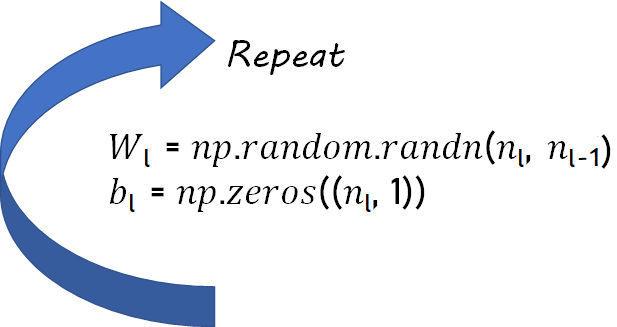






In [ ]:
def initialize_parameters(layer_dims):
  np.random.seed(42)
  L = len(layer_dims) - 1
  parameters =  {}
  for l in range(1 , L+1):
      parameters['W' + str(l)] = np.random.randn(layer_dims[l] , layer_dims[l-1]) *  np.sqrt(2. / layer_dims[l-1])
      parameters['b' + str(l)] = np.zeros((layer_dims[l] , 1))

  return parameters

#p = initialize_parameters([10 , 100 , 200 , 3])   # here we can especify num of layers and num of neurons

In [ ]:
layer_dims = [X_train.shape[0], 100, 200, 1]
params = initialize_parameters(layer_dims)

for l in range(1, len(layer_dims)):
    print("Shape of W" + str(l) + ":", params['W' + str(l)].shape)
    print("Shape of B" + str(l) + ":", params['b' + str(l)].shape, "\n")

Shape of W1: (100, 32)
Shape of B1: (100, 1) 

Shape of W2: (200, 100)
Shape of B2: (200, 1) 

Shape of W3: (1, 200)
Shape of B3: (1, 1) 



# Forward Propagation

* since we have a regression task , the f function for the last layer should be linear without any especific activation function

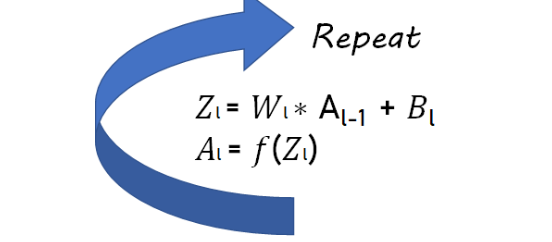

In [ ]:
def forward_propagation(X, parameters, activation = 'relu'):

    ## Complete the Code below : ##
  forward_cache = {}
  L =  len(parameters) //2                 # Must return the total number of layers in the network (Does not include Input layer)
  forward_cache['A0'] = X
    ## Your Code ends ##

  for l in range(1, L ):
        ## Your Code Here ##
      forward_cache['Z' + str(l)] =  parameters['W' + str(l)].dot(forward_cache['A'+str(l-1)])  + parameters['b' + str(l)]
      forward_cache['A' + str(l)] = globals()[activation](forward_cache['Z' + str(l)])


        ## Code Ends ##

    ## Forward Propagation for last layer ##

  forward_cache['Z' + str(L)] = parameters['W' + str(L)].dot(forward_cache['A'+str(L-1)]) + parameters['b' + str(L)]
  forward_cache['A' + str(L)] = globals()[activation](forward_cache['Z' + str(L)])  # without activation

    ## Your Code Ends ##
  return forward_cache['A' + str(L)], forward_cache

In [ ]:
aL, forw_cache = forward_propagation(X_train, params, 'relu')

for l in range(len(params)//2 + 1):
    print("Shape of A" + str(l) + " :", forw_cache['A' + str(l)].shape)



Shape of A0 : (32, 12285)
Shape of A1 : (100, 12285)
Shape of A2 : (200, 12285)
Shape of A3 : (1, 12285)


# **Cost Function**

In [ ]:
def compute_cost(AL, Y , parameters, lamda ):
    """
    Computes the mean squared error cost function.

    Arguments:
    AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    Y -- true "label" vector, shape (1, number of examples)

    Returns:
    cost -- mean squared error cost
    """
    m = Y.shape[1]
    cost = (1 / (2 * m)) * np.sum(np.square(AL - Y))

    # compute the L2 regularization term

    L=  len(parameters) // 2
    reg_term = 0
    for l in range(1 , L + 1):
      reg_term += np.sum(np.square(parameters['W' + str(l)]))

    reg_term = (lamda / (2 * m)) * reg_term

    cost = cost + reg_term

    cost = np.squeeze(cost)


    return cost

# **Back Propagation**

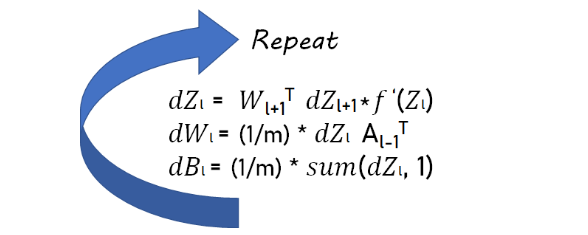

In [ ]:
def backward_propagation(AL, Y, parameters, forward_cache, activation , lambd):
    grads = {}
    L = len(parameters) // 2  # Number of layers in the neural network
    m = Y.shape[1]  # Number of examples

    # Gradient for the last layer (L-th layer)
    dAL = (2/m) * (AL - Y )
    grads["dZ" + str(L)] = dAL * derivative_relu(forward_cache['Z' + str(L)])

    grads["dW" + str(L)] = (1./m) * np.dot(grads['dZ' + str(L)], forward_cache['A' + str(L-1)].T) + (lambd / m) * parameters['W' + str(L)]
    grads["db" + str(L)] = (1./m) * np.sum(grads['dZ' + str(L)], axis=1, keepdims=True)

    # Loop through layers from L-1 to 1
    for l in reversed(range(1, L)):

        if activation == 'relu':
            grads['dZ' + str(l)] = np.dot(parameters['W' + str(l+1)].T, grads['dZ' + str(l+1)]) * derivative_relu(forward_cache['A' + str(l)])
        else:
            grads['dZ' + str(l)] =  np.dot(parameters['W' + str(l+1)].T, grads['dZ' + str(l+1)]) * derivative_tanh(forward_cache['A' + str(l)])


        grads["dW" + str(l)] = (1./m) * np.dot(grads['dZ' + str(L)], forward_cache['A' + str(l-1)].T) + (lambd / m) * parameters['W' + str(l)]
        grads["db" + str(l)] = (1./m) * np.sum(grads['dZ' + str(L)], axis=1, keepdims=True)

    return grads


In [ ]:
grads = backward_propagation(forw_cache["A" + str(3)], y_train, params, forw_cache, 'relu' , lambd = 1)

for l in reversed(range(1, len(grads)//3 + 1)):
    print("Shape of dZ" + str(l) + " :", grads['dZ' + str(l)].shape)
    print("Shape of dW" + str(l) + " :", grads['dW' + str(l)].shape)
    print("Shape of dB" + str(l) + " :", grads['db' + str(l)].shape, "\n")

Shape of dZ3 : (1, 12285)
Shape of dW3 : (1, 200)
Shape of dB3 : (1, 1) 

Shape of dZ2 : (200, 12285)
Shape of dW2 : (200, 100)
Shape of dB2 : (1, 1) 

Shape of dZ1 : (100, 12285)
Shape of dW1 : (100, 32)
Shape of dB1 : (1, 1) 



# **Update Parameter**



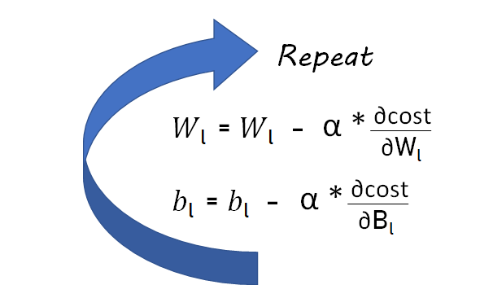

In [ ]:
def update_parameters(parameters, grads, learning_rate):

  L = len(parameters) // 2

  for l in range(1,L+1):
      parameters["W" + str(l)] = parameters["W" + str(l)] - learning_rate * grads["dW" + str(l)]
      parameters["b" + str(l)] = parameters["b" + str(l)] - learning_rate * grads["db" + str(l)]

  return parameters

# **Prediction**

In [ ]:
def mean_absolute_percentage_error(X, y_true , parameters ):
    """
    Calculate MAPE between actual and predicted values.

    Parameters:
    y_true (numpy array): Array of actual values
    y_pred (numpy array): Array of predicted values

    Returns:
    float: MAPE value
    """
    y_pred , _  = forward_propagation(X, parameters, activation = 'relu')
    # Avoid division by zero by replacing zeros in y_true
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)

    # Calculate MAPE
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape

In [ ]:
mean_absolute_percentage_error(X_test, y_test, params )       # mean absolute percentage error before traing model.

'The mean absolute error is : , 99.13522055906388'

# **Hyperparameter tuning using cross validation**

In [ ]:
def model(X , Y , layer_dims , learning_rate , activation  = 'relu' , iter = 100 , lambd = 1):

  parameters =  initialize_parameters(layer_dims)

  for i in range(0 , iter):

    AL , forward_cache = forward_propagation(X , parameters , activation )

    cost = compute_cost(AL , Y , parameters , lambd)

    grads = backward_propagation(AL , Y , parameters , forward_cache , activation , lambd )

    update_parameters(parameters , grads , learning_rate)

    if i % (iter  / 10) == 0:
      print(f'cost is :  {cost} \t and the MAPE for train is {mean_absolute_percentage_error(X_train, y_train , parameters )} \t and MAPE for validation is {mean_absolute_percentage_error(X_valid, y_valid , parameters )}' )


  return parameters

In [ ]:

start_time = time.time()

def k_fold_cross_validation(X, Y, layer_configs, learning_rates, lambdas, num_iterations, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    best_cost = float('inf')
    best_params = {'learning_rate': None, 'lambd': None, 'layer_config': None}

    all_train_mape = []
    all_valid_mape = []
    for layers in layer_configs:

        for lr in learning_rates:

            for lambd in lambdas:

                print(f'eval lambd {lambd} \t eval architecture {layers} \t eval learning rate {lr}')
                fold_costs = []
                fold_train_mape = []
                fold_valid_mape = []

                for train_index, valid_index in kf.split(X.T):  # X.T because kf.split expects samples as rows
                    # DataFrame slicing for training and validation sets
                    X_train_cv = X.iloc[:, train_index].values  # Convert to NumPy array
                    X_valid_cv = X.iloc[:, valid_index].values   # Convert to NumPy array

                    # y_train is already in the shape (1, num_samples), no need to transpose
                    Y_train_cv = Y[:, train_index]  # Slicing columns
                    Y_valid_cv = Y[:, valid_index]  # Slicing columns

                    # Train model and compute cost
                    parameters = model(X_train_cv, Y_train_cv, layers, learning_rate=lr, activation='relu', iter=num_iterations, lambd=lambd)

                    # MAPE for the training set
                    AL_train, _ = forward_propagation(X_train_cv, parameters, activation='relu')
                    train_mape = mean_absolute_percentage_error( X_train_cv , Y_train_cv, parameters)
                    fold_train_mape.append(train_mape)

                    # MAPE for the validation  set
                    AL_valid, _ = forward_propagation(X_valid_cv, parameters, activation='relu')
                    valid_mape = mean_absolute_percentage_error( X_valid_cv , Y_valid_cv, parameters)
                    fold_valid_mape.append(valid_mape)


                    cost = compute_cost(AL_valid, Y_valid_cv, parameters, lambd)
                    fold_costs.append(cost)


                # Average fold MAPE and costs
                avg_cost = np.mean(fold_costs)
                avg_train_mape = np.mean(fold_train_mape)
                avg_valid_mape = np.mean(fold_valid_mape)

                print(f'Average Cost: {avg_cost}')
                print(f'Average Training MAPE: {avg_train_mape}%')
                print(f'Average Validation MAPE: {avg_valid_mape}%')

                all_train_mape.append(avg_train_mape)
                all_valid_mape.append(avg_valid_mape)


                if avg_cost < best_cost:
                    best_cost = avg_cost
                    best_params = {'learning_rate': lr, 'lambd': lambd, 'layer_config': layers}

    return best_params , np.mean(all_train_mape), np.mean(all_valid_mape)

# Example usage:
layer_configs = [
     # 32 input features, adjusting layers as needed
    [32, 80, 60, 20, 1],
    [32, 60, 30 , 20, 1]
]
learning_rates = [0.001, 0.006, 0.01]
lambdas = [0.01, 0.1, 1 ]
num_iterations = 800
k = 5  # Number of folds for cross-validation

# Ensure X_train and y_train are correct
# Ensure X_train and y_train are correct
best_params, avg_train_mape, avg_valid_mape = k_fold_cross_validation(X_train, y_train, layer_configs, learning_rates, lambdas, num_iterations, k=k)
print(f'Best hyperparameters and architecture: {best_params}')
print()
print(f'Final Average Training MAPE (K-Fold): {avg_train_mape}%')
print()
print(f'Final Average Validation MAPE (K-Fold): {avg_valid_mape}%')

end_time = time.time()
execution_time = end_time - start_time
print(f'Execution time: {execution_time} seconds')
print()
# Train final model with best parameters
final_parameters = model(X_train, y_train, best_params['layer_config'], learning_rate=best_params['learning_rate'], activation='relu', iter=num_iterations, lambd=best_params['lambd'])

# Evaluate on test set
AL_test, _ = forward_propagation(X_test, final_parameters, activation='relu')  # Make sure X_test is similarly structured
test_cost = compute_cost(AL_test, y_test, final_parameters, best_params['lambd'])

print(f'Test cost: {test_cost}')
print(f'Test MAPE: {mean_absolute_percentage_error(X_test, y_test, final_parameters)}')


eval lambd 0.01 	 eval architecture [32, 80, 60, 20, 1] 	 eval learning rate 0.001
cost is :  810.5354127081794 	 and the MAPE for train is 97.86353522820998 	 and MAPE for validation is 97.86596336352542
cost is :  807.678462009405 	 and the MAPE for train is 97.6976761921342 	 and MAPE for validation is 97.70172910538899
cost is :  803.9866611572929 	 and the MAPE for train is 97.50498808584123 	 and MAPE for validation is 97.51195528731711
cost is :  799.7945473534853 	 and the MAPE for train is 97.29362397331191 	 and MAPE for validation is 97.30360294192843
cost is :  794.9414927719848 	 and the MAPE for train is 97.05564705556188 	 and MAPE for validation is 97.06996143850276
cost is :  789.4194818262981 	 and the MAPE for train is 96.78310410582189 	 and MAPE for validation is 96.80250083046464
cost is :  783.51597037425 	 and the MAPE for train is 96.48606203375661 	 and MAPE for validation is 96.509117880176
cost is :  778.4609366545984 	 and the MAPE for train is 96.195322854

# **Traing model using best parameters**

In [ ]:
layer_dims = [X_train.shape[0], 32, 80 ,60,20 , 1]
lr = 0.01
iters = 1500
# Best hyperparameters and architecture: {'learning_rate': 0.01, 'lambd': 0.01, 'layer_config': [32, 80, 60, 20, 1]}
parameters = model(X_train , y_train , layer_dims  , learning_rate = lr , activation = 'relu' , iter = iters , lambd= 0.01 )



cost is :  788.5724393651434 	 and the MAPE for train is 96.16955454654105 	 and MAPE for validation is 96.17183603690995
cost is :  461.9289510568537 	 and the MAPE for train is 78.76940086767216 	 and MAPE for validation is 79.06780322673117
cost is :  126.1062695051736 	 and the MAPE for train is 37.968769432779176 	 and MAPE for validation is 37.74027579447349
cost is :  104.5775787222633 	 and the MAPE for train is 32.52000204246491 	 and MAPE for validation is 32.28621187344658
cost is :  90.07175682404126 	 and the MAPE for train is 29.233256655165025 	 and MAPE for validation is 29.171383179664556
cost is :  79.82193109955796 	 and the MAPE for train is 27.038476124648312 	 and MAPE for validation is 27.07690883446217
cost is :  72.48828876387292 	 and the MAPE for train is 25.577640861339624 	 and MAPE for validation is 25.691580184343305
cost is :  67.14113187021246 	 and the MAPE for train is 24.603455826890993 	 and MAPE for validation is 24.7842267473369
cost is :  63.1932

# **Test Error**

In [ ]:
mean_absolute_percentage_error(X_test, y_test, parameters )

23.862479040679375